# NHMRC Ideas Grants: Funding Data Analysis

This notebook:
1. Loads **Yearly summary** and **Categories** tables from `data/`.
2. Plots **actual pot vs pot needed for a 10% success rate** (2019–2025).
3. Plots a **projection** (2025–2030) using fixed annual assumptions (editable).
4. Computes and plots **Category 6 ("Outstanding") unfunded** applications (lower bound), as count and %.

The analysis imports reusable functions from `src/utils.py` to avoid duplicating code.



**Data source:** Data were obtained from the NHMRC website and/or assessment reports from previous grant application rounds. The specific source (URL or document reference) is provided in the “Source” column for each dataset

**Author:** Jose A Caparros-Martin

**Date:** Jan 4th, 2026

___

#### 1. Setup

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  1.1 Running this notebook in Google Colab
</div>

In [ ]:
# If you are running in Colab by opening this notebook from GitHub,
# you may need to clone the repo so relative paths like ../data/... work.

import os
from pathlib import Path

IN_COLAB = "COLAB_GPU" in os.environ

# Colab users: if you opened this notebook from GitHub and get "file not found",
# uncomment these lines to clone the repo into Colab and cd into it:
# !git clone https://github.com/jacapmar/Project_Ideas.git
# %cd Project_Ideas

Path.cwd()


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  1.2 Imports and project paths
</div>

In [ ]:
# Imports + locate repo root + make it importable (so `from src.utils import ...` works)

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Find repo root by walking upward until we see `src/` and `data/`
p = Path.cwd().resolve()
while not ((p / "src").exists() and (p / "data").exists()) and p != p.parent:
    p = p.parent
REPO = p

if str(REPO) not in sys.path:
    sys.path.insert(0, str(REPO))

REPO

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  1.3 Import helper functions (src/utils.py)
</div>

In [125]:
# Import helper functions from src/utils.py

from src.utils import (
    load_yearly_csv,
    load_categories_csv,
    add_pot_metrics,
    category6_unfunded_summary,
    project_from_base,
    plot_pot_vs_needed_with_projection,
    plot_cat6_unfunded,
)

_____

#### 2. Load data

In [127]:
# Load data (CSV)

YEARLY_PATH = REPO / "data" / "Yearly_summary.csv"
CATS_PATH   = REPO / "data" / "Categories.csv"

# CSV settings
SEP = ";"
DECIMAL = "."   
THOUSANDS = None  

yearly = load_yearly_csv(str(YEARLY_PATH), sep=SEP, decimal=DECIMAL, thousands=THOUSANDS)
cats   = load_categories_csv(str(CATS_PATH), sep=SEP, decimal=DECIMAL, thousands=THOUSANDS)

yearly.head()

,Year,Total commitment ($AUD million),Grants funded,Applications received,Applying for NHMRC funding,Success rate (%),Mean budget awarded grants (AUD),Budget distribution Salary,Budget distribution other,Budget distribution equipment,Source
0,2019,241.70,294,2739,2651.0,11.10,822258.82,NaN,NaN,NaN,https://www.nhmrc.gov.au/sites/default/files/d...
1,2020,259.70,283,2995,2889.0,9.80,917747.57,NaN,NaN,NaN,https://www.nhmrc.gov.au/sites/default/files/d...
2,2021,239.23,248,2639,2503.0,9.90,964640.56,NaN,NaN,NaN,https://www.nhmrc.gov.au/sites/default/files/d...
3,2022,240.92,232,2193,2109.0,11.00,1038436.92,NaN,NaN,NaN,https://www.nhmrc.gov.au/sites/default/files/d...
4,2023,268.39,232,2182,NaN,11.06,1160000.00,65.0,34.5,0.6,https://www.nhmrc.gov.au/sites/default/files/d...


In [129]:
cats.head()

,Category,Year,Number of grants,Percentage,Source
0,2,2022,3,0.135624,Assessment report information related to previ...
1,3,2022,9,0.406872,Assessment report information related to previ...
2,4,2022,335,15.144665,Assessment report information related to previ...
3,5,2022,1479,66.862568,Assessment report information related to previ...
4,6,2022,366,16.546112,Assessment report information related to previ...


#### 3. Analysis

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.1 Compute required pot for 10% success
</div>

In [131]:
# Derived metrics for yearly (adds pot_needed_10pct_M, gap_to_10pct_M)

yearly = add_pot_metrics(
    yearly,
    apps_col="Applications received",
    award_col="Mean budget awarded grants (AUD)",
    pot_col="Total commitment ($AUD million)",
)

yearly[["Year", "Total commitment ($AUD million)", "pot_needed_10pct_M", "gap_to_10pct_M"]].tail()


,Year,Total commitment ($AUD million),pot_needed_10pct_M,gap_to_10pct_M
2,2021,239.23,254.568644,15.338644
3,2022,240.92,227.729217,-13.190783
4,2023,268.39,253.112000,-15.278000
5,2024,274.35,278.103000,3.753000
6,2025,279.87,345.009000,65.139000


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
   3.2 Assumptions for the 2025-2030 projection. <strong>  The values can be modified if you want to make different projections.</strong>
</div>

In [177]:
# Projection assumptions (annual) — Values match the overall 2019-2025 trend

pot_g   = 0.0247   # Total commitment from NHMRC increases +2.47%/yr
award_g = 0.1017  # Mean award value increases +10.17%/yr
apps_g  = -0.0254  # Number of applications decrease by -2.54%/yr

base_year = 2025
horizon   = 5   # 2025..2030

In [179]:
# Build projection table (2025..2030)

proj = project_from_base(
    yearly,
    base_year=base_year,
    horizon=horizon,
    pot_g=pot_g,
    award_g=award_g,
    apps_g=apps_g,
    year_col="Year",
    pot_col="Total commitment ($AUD million)",
    award_col="Mean budget awarded grants (AUD)",
    apps_col="Applications received",
)

proj


,Year,Pot_M,PotNeeded10pct_M,Success_implied_pct
0,2025,279.870000,345.009000,8.111962
1,2026,286.782789,370.441966,7.741639
2,2027,293.866324,397.749770,7.388221
3,2028,301.124822,427.070618,7.050937
4,2029,308.562605,458.552906,6.729051
5,2030,316.184102,492.355968,6.421860


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.3 Represent the 2025-2030 projection
</div>

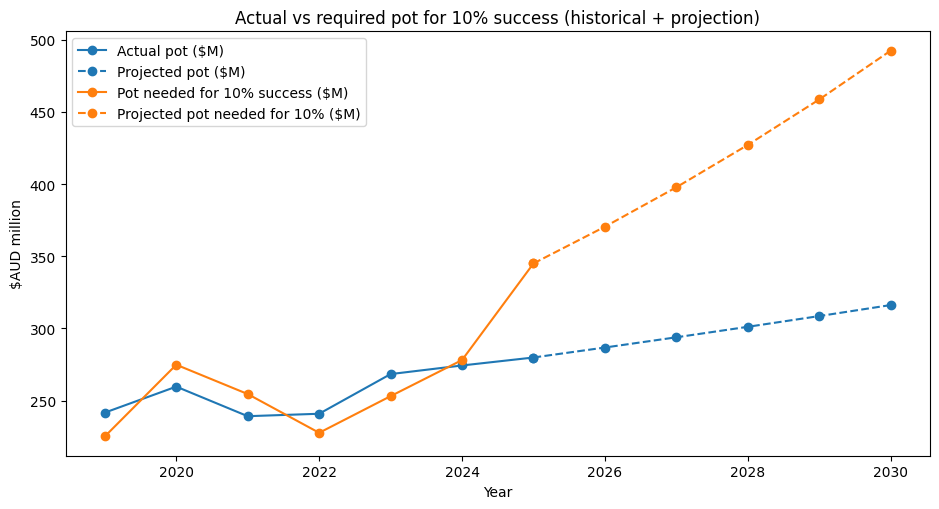

In [181]:
# Chart 1: Actual (2019–2025) + Projected (2025–2030)
# solid = actual, dashed = projected (same color per metric)

plot_pot_vs_needed_with_projection(
    yearly=yearly,
    proj=proj,
    start_year=2019,
    hist_end=2025,
    proj_end=2030,
    year_col="Year",
    pot_col="Total commitment ($AUD million)",
    needed_col="pot_needed_10pct_M",
    proj_pot_col="Pot_M",
    proj_needed_col="PotNeeded10pct_M",
    title="Actual vs required pot for 10% success (historical + projection)",
)

plt.show()

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.4 Compute Category 6 (‘Outstanding’) unfunded (lower bound)
</div>

In [139]:
# Category 6 unfunded (lower bound) summary

summary = category6_unfunded_summary(
    cats=cats,
    yearly=yearly,
    funded_col="Grants funded",
    year_col="Year",
    category_col="Category",
    count_col="Number of grants",
    cat6=6,
    cat7=7,
)

summary.head()

,Year,Cat6,Cat6plus7,Funded_total,Outstanding_unfunded_lowerbound,Outstanding_unfunded_pct_lowerbound
0,2021,366.0,366.0,248.0,118.0,32.240437
1,2022,366.0,366.0,232.0,134.0,36.612022
2,2023,368.0,369.0,232.0,136.0,36.956522
3,2024,437.0,437.0,223.0,214.0,48.970252
4,2025,494.0,494.0,190.0,304.0,61.538462


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.5 Represent number of Category 6 applications not funded
</div>

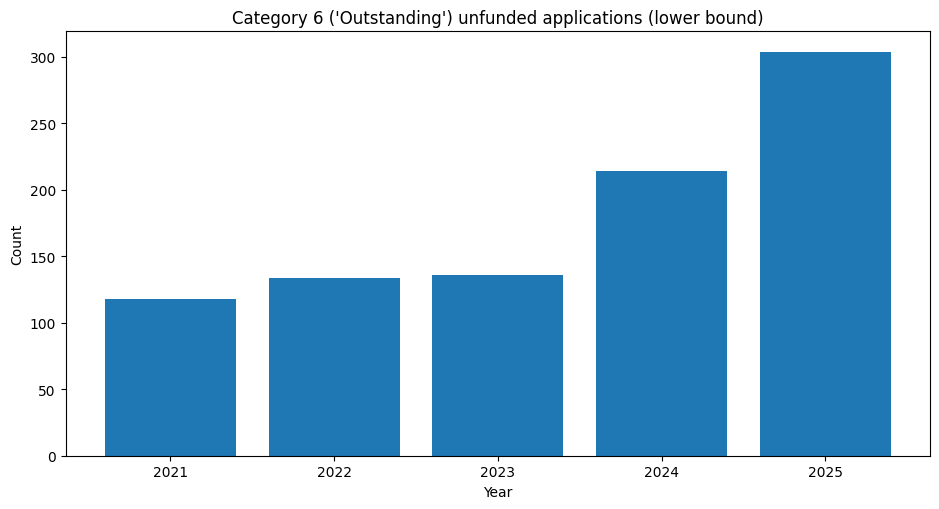

In [141]:
# Chart 2a: Category 6 unfunded (lower bound) — COUNT

plot_cat6_unfunded(summary, mode="count")
plt.show()


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.6 Represent percentage of Category 6 applications not funded
</div>

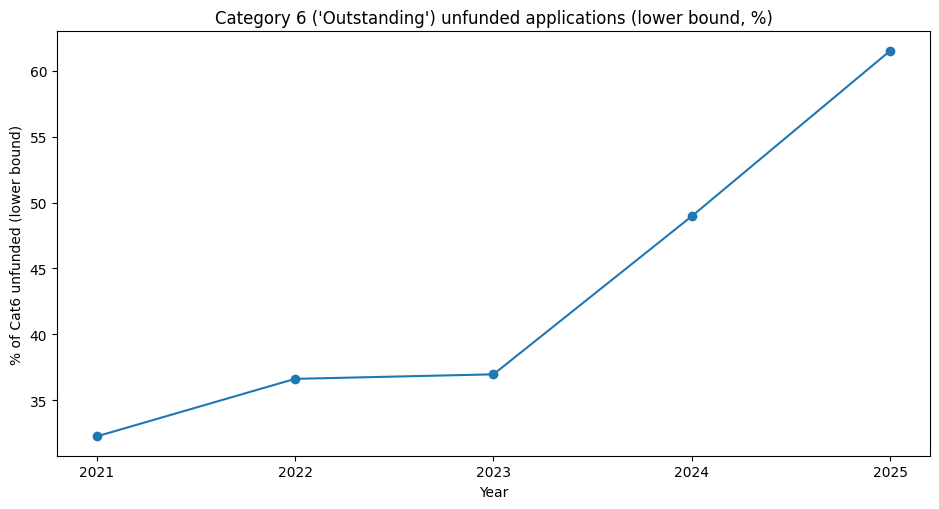

In [143]:
# Chart 2b: Category 6 unfunded (lower bound) — PERCENT

plot_cat6_unfunded(summary, mode="pct")
plt.show()

____